In [1]:
# import all libraries here
import os
import pathlib
import xml.etree.ElementTree as ET
from PIL import Image
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
import datetime as dt
from tensorflow.keras import backend as K
from tensorflow.keras.applications.densenet import DenseNet121,preprocess_input

In [2]:
TEST_SIZE = 0.2
RANDOM_SEED = 28

targetx = 224
targety = 224

batch_size = 32

learning_rate =  0.0001

np.random.seed(RANDOM_SEED)

In [3]:
ANNOTATION_DIR = pathlib.Path('../input/stanford-dogs-dataset/annotations/Annotation')
IMAGES_DIR = pathlib.Path('../input/stanford-dogs-dataset/images/Images')

BREED_DIR = [path for path in IMAGES_DIR.iterdir()]
BREED_DIR_NAME = [path.name for path in BREED_DIR]

BREED_CODE_TO_NAME = {breed.split('-')[0]: breed.split('-')[1] for breed in BREED_DIR_NAME}


BREED_CODE_TO_NAME = {breed.split('-')[0]: breed.split('-')[1] for breed in BREED_DIR_NAME}


BREED_NAME_TO_CODE = {v: k for k, v in BREED_CODE_TO_NAME.items()}


BREED_LABEL_TO_CODE = {i: code for i, code in enumerate(BREED_CODE_TO_NAME)}


BREED_CODE_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_CODE.items()}


BREED_LABEL_TO_NAME = {i: BREED_CODE_TO_NAME[code] for i, code in BREED_LABEL_TO_CODE.items()}


BREED_NAME_TO_LABEL = {v: k for k, v in BREED_LABEL_TO_NAME.items()}

In [4]:
def path_to_label(path):
    code = path.stem.split('_')[0]
    return BREED_CODE_TO_LABEL[code]

def get_all_file_path(directory, file_pattern=''):
    paths = list(f for f in directory.rglob('**/*{}'.format(file_pattern)) if f.is_file())
    return sorted(paths, key=str)

In [5]:
all_image_paths = get_all_file_path(IMAGES_DIR, '.jpg') # PosixPath

all_image_labels = [path_to_label(path) for path in all_image_paths]

assert len(all_image_paths)==len(all_image_labels), 'Numbers of images and labels not match! {}!={}'.format(len(all_image_paths), len(all_image_labels))

In [6]:
%%time
with open('labels.txt', 'w') as f:
    f.write('\n'.join(BREED_NAME_TO_LABEL))# Write labels to file

CPU times: user 1.67 ms, sys: 0 ns, total: 1.67 ms
Wall time: 2.61 ms


In [7]:
# Crop and save images according to boundings

# making a directory to save cropped images
IMAGES_CROPPED_DIR = pathlib.Path('/kaggle/working/images_cropped/')
IMAGES_CROPPED_DIR.mkdir(parents=True, exist_ok=True) 
print('done')

done


In [8]:
# Gets object boundings
def parse_bounding(path):
    # Get annotation path from image path
    path = ANNOTATION_DIR / path.parent.name / path.stem
    
    # Parse boundings
    tree = ET.parse(path)
    bndbox = tree.getroot().findall('object')[0].find('bndbox')
    left = int(bndbox.find('xmin').text)
    right = int(bndbox.find('xmax').text) 
    upper = int(bndbox.find('ymin').text)
    lower = int(bndbox.find('ymax').text) 
    
    return (left, upper, right, lower)

In [9]:
def crop_and_save_image(path, save_dir=IMAGES_CROPPED_DIR):
    box = parse_bounding(path)
    
    image = Image.open(path)
    image_cropped = image.crop(box)
    image_cropped = image_cropped.convert('RGB')
    image_cropped.save(save_dir / path.name)

In [10]:
%%time
try:
    pool = mp.Pool(processes=mp.cpu_count())
    pool.map(crop_and_save_image, all_image_paths)
except Exception as e:
    print(e)
finally:
    pool.close()

CPU times: user 176 ms, sys: 74.1 ms, total: 250 ms
Wall time: 4min 7s


In [11]:
all_image_cropped_paths = get_all_file_path(IMAGES_CROPPED_DIR, '.jpg') # PosixPath
all_image_cropped_labels = [path_to_label(path) for path in all_image_cropped_paths] # [0,1,2,...]

In [12]:
assert len(all_image_paths)==len(all_image_cropped_paths), 'Numbers of images and cropped images not match! {}!={}'.format(len(all_image_paths), len(all_image_cropped_paths))

In [13]:
IMAGE_PATH = all_image_cropped_paths
LABEL = all_image_cropped_labels

In [14]:
x_train, x_test, y_train, y_test = train_test_split(IMAGE_PATH, 
                                                    LABEL,
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True,
                                                    stratify=LABEL)

print('Train data: ', len(x_train))
print('Test data: ', len(x_test))

Train data:  16464
Test data:  4116


In [15]:
classes = BREED_NAME_TO_CODE.keys()

TRAIN_DIR = pathlib.Path('/kaggle/working/train_dir/')
TRAIN_DIR.mkdir(parents=True, exist_ok=True)

VALIDATION_DIR = pathlib.Path('/kaggle/working/val_dir/')
VALIDATION_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
def make_classes_folder(folder_path):
    for c in classes:
        path = folder_path / c
        path.mkdir()
        
make_classes_folder(TRAIN_DIR)
make_classes_folder(VALIDATION_DIR)

In [17]:
%%time
def copy_img_to_folder(path_array,folder_path):
    for img_path in path_array:
        code_to_label = BREED_CODE_TO_NAME.get(img_path.stem.split('_')[0])
        image = Image.open(img_path)
        image.save(folder_path / code_to_label / img_path.name)
        
copy_img_to_folder(x_train,TRAIN_DIR)

copy_img_to_folder(x_test,VALIDATION_DIR)

CPU times: user 3min 23s, sys: 2.11 s, total: 3min 25s
Wall time: 3min 26s


In [18]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode = 'nearest',
        validation_split=TEST_SIZE,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=RANDOM_SEED,
        subset="training"
)


test_generator = datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=RANDOM_SEED,
        subset="validation"
)

Found 13210 images belonging to 120 classes.
Found 784 images belonging to 120 classes.


In [19]:
checkpoint = ModelCheckpoint('dog_breed_classifier.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            batch_size=batch_size,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=20,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [20]:
%%time
inpt = Input(shape=(targetx,targety,3))
backbone = DenseNet121(input_tensor=inpt,
                       weights="imagenet",
                       include_top=False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dense(1280, activation='relu',  kernel_initializer=glorot_uniform(RANDOM_SEED), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
outp = Dense(120, activation="softmax",kernel_initializer='random_uniform', bias_initializer='zeros')(x)
model = Model(inpt, outp)

29089792/29084464 [==============================] - 0s 0us/step
CPU times: user 6.99 s, sys: 838 ms, total: 7.83 s
Wall time: 9.94 s


In [21]:
######
e = 20
######
loss = "categorical_crossentropy"
optimizer = Adam(lr=learning_rate)

for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])
params = model.fit_generator(generator=train_generator, 
                                steps_per_epoch=len(train_generator)//2, 
                                validation_data=test_generator, 
                                validation_steps=len(test_generator),
                                epochs=e,
                                callbacks=[reducelr,earlystop, lambdacb, tensorboard, checkpoint])


Learning rate:  1e-04
Epoch 1/20
206/206 [==============================] - ETA: 0s - loss: 2.3417 - accuracy: 0.4649
Epoch 00001: val_accuracy improved from -inf to 0.72577, saving model to dog_breed_classifier.h5
206/206 [==============================] - 141s 684ms/step - loss: 2.3417 - accuracy: 0.4649 - val_loss: 1.2730 - val_accuracy: 0.7258 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/20
206/206 [==============================] - ETA: 0s - loss: 0.8727 - accuracy: 0.7592
Epoch 00002: val_accuracy improved from 0.72577 to 0.76020, saving model to dog_breed_classifier.h5
206/206 [==============================] - 137s 667ms/step - loss: 0.8727 - accuracy: 0.7592 - val_loss: 0.8963 - val_accuracy: 0.7602 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 3/20
206/206 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.8318
Epoch 00003: val_accuracy improved from 0.76020 to 0.77041, saving model to dog_breed_classifier.h5
206/206 [==============================] - 13

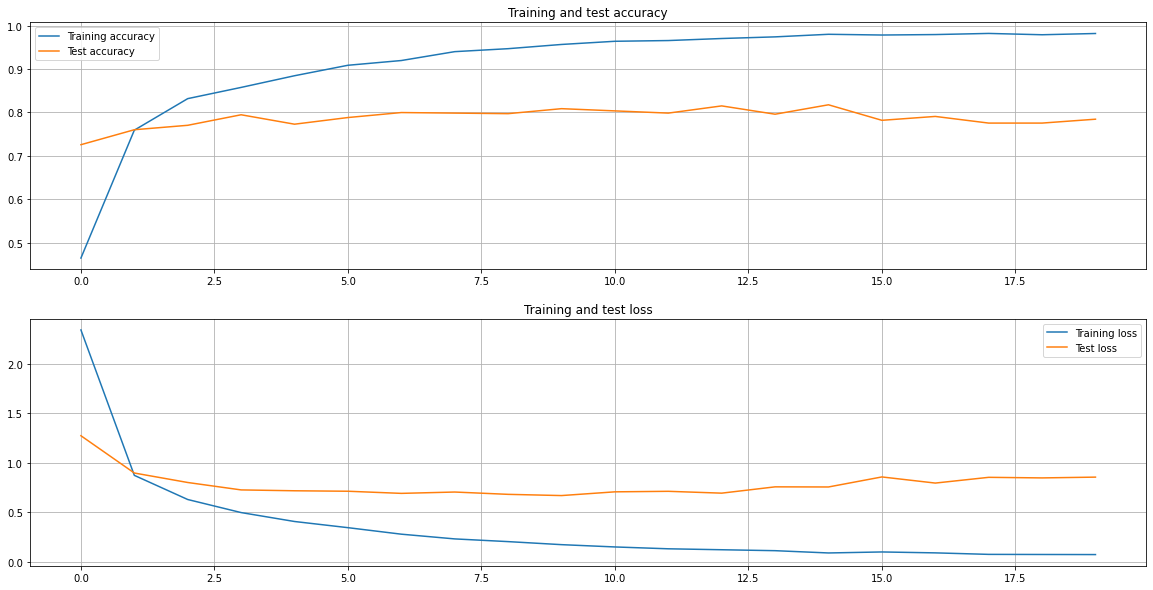

In [22]:
plt.rcParams["figure.figsize"] = [20,10]
plt.subplot(2, 1, 1)
plt.title('Training and test accuracy')
plt.plot(params.epoch, params.history['accuracy'], label='Training accuracy')
plt.plot(params.epoch, params.history['val_accuracy'], label='Test accuracy')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Training and test loss')
plt.plot(params.epoch, params.history['loss'], label='Training loss')
plt.plot(params.epoch, params.history['val_loss'], label='Test loss')
plt.legend()
plt.grid(True)

plt.show()